# Preprocessing

## Function

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Function_postcodes as fp
import re
import scipy
from sklearn import set_config

set_config(transform_output = 'pandas')

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree

## Correlations and  null values

In [106]:
os.getcwd()

'/Users/dm1223/Desktop/ads-deluge-jubilee/flood_tool'

<Axes: >

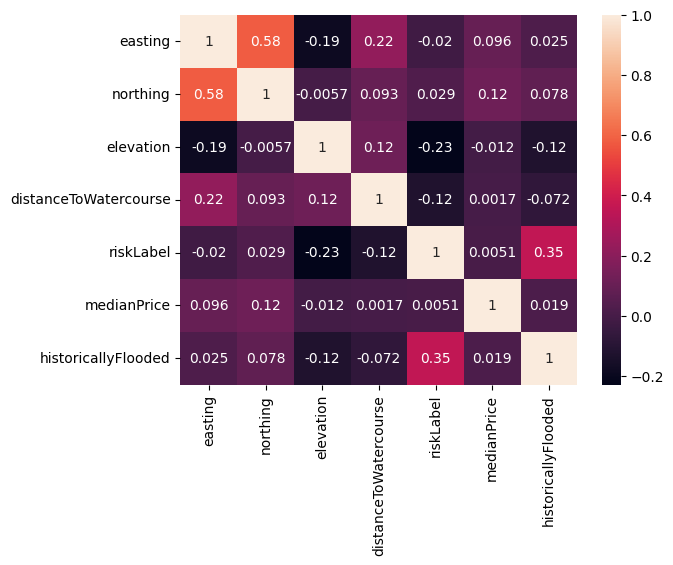

In [107]:
ostcodes_labelled = pd.read_csv('resources/postcodes_labelled.csv')
correlations = postcodes_labelled.select_dtypes(include=np.number).corr()
sns.heatmap(correlations, annot=True)

In [108]:
data = postcodes_labelled.copy()
data.drop_duplicates(inplace=True)
data.isnull().sum()
#data['nearestWatercourse'].fillna('No_Watercourse_Near', inplace= True)


postcode                     0
easting                      0
northing                     0
soilType                     0
elevation                    0
nearestWatercourse       30091
distanceToWatercourse        0
localAuthority               0
riskLabel                    0
medianPrice               6202
historicallyFlooded          0
dtype: int64

In [109]:
data['nearestWatercourse'].nunique()

1146

## Imputer and Latitude/Longitude

In [110]:
from sklearn.impute import SimpleImputer
new = SimpleImputer(strategy='median')
data['medianPrice'] = new.fit_transform(data['medianPrice'].values.reshape(-1,1))

In [111]:
import os
os.getcwd()
os.chdir('/Users/dm1223/Desktop/ads-deluge-jubilee/flood_tool')

In [112]:

from flood_tool.geo import get_gps_lat_long_from_easting_northing
coordinates_lat = get_gps_lat_long_from_easting_northing(data['easting'], data['northing'])
coordinates_df = pd.DataFrame({
    'latitude': coordinates_lat[0],
    'longitude': coordinates_lat[1]
})
data = pd.concat([data, coordinates_df], axis=1)
data.drop(columns=['easting', 'northing'], inplace=True)

In [113]:
# missing_watercourse  = data[data['nearestWatercourse'].isnull()].index
# data.iloc[missing_watercourse, :]

In [114]:
# def lat_lon_to_cartesian(lat, lon, elevation, earth_radius=6371):
#     """
#     Converts latitude, longitude, and elevation to 3D Cartesian coordinates.
    
#     Args:
#         lat (float): Latitude in degrees.
#         lon (float): Longitude in degrees.
#         elevation (float): Elevation in meters.
#         earth_radius (float): Radius of the Earth in kilometers (default: 6371).
    
#     Returns:
#         tuple: Cartesian coordinates (x, y, z).
#     """
#     # Convert latitude and longitude to radians
#     lat_rad = np.radians(lat)
#     lon_rad = np.radians(lon)
    
#     # Earth's radius + elevation (convert elevation from meters to kilometers)
#     r = earth_radius + (elevation / 1000.0)
    
#     # Cartesian coordinates
#     x = r * np.cos(lat_rad) * np.cos(lon_rad)
#     y = r * np.cos(lat_rad) * np.sin(lon_rad)
#     z = r * np.sin(lat_rad)
#     return x, y, z

# def impute_watercourse_3d(df, lat_col="latitude", lon_col="longitude", elev_col="elevation", watercourse_col="nearestWatercourse"):
#     """
#     Impute missing watercourse names using 3D Cartesian distance.
    
#     Args:
#         df (pd.DataFrame): The dataset with latitude, longitude, elevation, and watercourse names.
#         lat_col (str): Column name for latitude.
#         lon_col (str): Column name for longitude.
#         elev_col (str): Column name for elevation.
#         watercourse_col (str): Column name for watercourse names.
    
#     Returns:
#         pd.DataFrame: Dataset with missing watercourse names imputed.
#     """
#     # Convert known and unknown locations to Cartesian coordinates
#     df["cartesian"] = df.apply(lambda row: lat_lon_to_cartesian(row[lat_col], row[lon_col], row[elev_col]), axis=1)
    
#     # Split data into known and unknown watercourses
#     known = df[df[watercourse_col].notna()]
#     unknown = df[df[watercourse_col].isna()]
    
#     # Build KDTree for known Cartesian coordinates
#     known_coords = np.array(known["cartesian"].tolist())
#     tree = KDTree(known_coords)
    
#     # Query nearest neighbors for unknown Cartesian coordinates
#     unknown_coords = np.array(unknown["cartesian"].tolist())
#     distances, indices = tree.query(unknown_coords, k=1)
    
#     # Flatten indices array to 1D
#     indices = indices.flatten()
    
#     # Impute missing values with the nearest neighbor's watercourse name
#     unknown[watercourse_col] = known.iloc[indices][watercourse_col].values
#     print(unknown)
#     # Combine known and updated unknown datasets
#     new = pd.concat([known, unknown], axis=0).drop(columns=["cartesian"])
    
#     return new

In [115]:
#Extracting the sector and district from the postcode
data[['postcodeSector','postcodeDistrict']] = data['postcode'].apply(lambda post: pd.Series([fp.postcode_to_sector(post), fp.postcode_to_district(post)])) 

In [116]:
from Function_postcodes import normalise_sector

sector_data = pd.read_csv('/Users/dm1223/Desktop/ads-deluge-jubilee/flood_tool/resources/sector_data.csv')
for index, sector in enumerate(sector_data['postcodeSector']):
    sector_data.loc[index, 'postcodeSector'] = normalise_sector(sector_data.loc[index, 'postcodeSector']) #using that as it will be possible in future pandas version
sector_data.head()

,postcodeSector,households,numberOfPostcodeUnits,headcount
0,AL1 1,2546,311,6080
1,AL1 2,2642,236,6942
2,AL1 3,2272,388,5821
3,AL1 4,3707,339,9635
4,AL1 5,4406,347,10560


In [117]:
#sns.pairplot(sector_data) # both households and headcounts are skewed

In [118]:
sector_data.head()

,postcodeSector,households,numberOfPostcodeUnits,headcount
0,AL1 1,2546,311,6080
1,AL1 2,2642,236,6942
2,AL1 3,2272,388,5821
3,AL1 4,3707,339,9635
4,AL1 5,4406,347,10560


### Households, Headcount

In [119]:
sectors = np.array(sector_data['postcodeSector'])
median_households = np.median(sector_data['households'])
data['households'] = np.zeros(len(data))
data['headcount'] = np.zeros(len(data))
headcounts = np.array(sector_data['headcount'])
median_headcounts = np.median(sector_data['headcount'])

In [120]:
for index, sector in enumerate(data['postcodeSector']):
    # Check if the sector exists in `sectors`
    if sector in sectors:
        # Find the corresponding number of households
        n_households = sector_data.loc[sector_data['postcodeSector'] == sector, 'households'].values[0]
        n_headcounts = sector_data.loc[sector_data['postcodeSector'] == sector, 'headcount'].values[0]

        if (n_households > 0) & (n_households != np.nan): data.loc[index, 'households'] = n_households
        else: data.loc[index, 'households'] = median_households

        if (n_headcounts > 0) & (n_headcounts != np.nan): data.loc[index, 'headcount'] = n_headcounts
        else: data.loc[index, 'households'] = median_households


In [121]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer

IMPUTATION_CONSTANTS = {
    "soilType": "Unsurveyed/Urban",
    "elevation": 60.0,
    "nearestWatercourse": "",
    "distanceToWatercourse": 80,
    "localAuthority": np.nan,
}

def impute_missing_values(
    data: pd.DataFrame,
    method: str = 'knn',
    n_neighbors: int = 4,
    constant_values: dict = IMPUTATION_CONSTANTS,
) -> pd.DataFrame:
    """Impute missing values in a dataframe.

    Parameters
    ----------

    dataframe : pandas.DataFrame
        DataFrame (in the format of the unlabelled postcode data)
        potentially containing missing values as NaNs, or with missing
        columns.

    method : str, optional
        Method to use for imputation. Options include:
        - 'mean', to use the mean for the labelled dataset
        - 'constant', to use a constant value for imputation
        - 'knn' to use k-nearest neighbours imputation from the
            labelled dataset

    constant_values : dict, optional
        Dictionary containing constant values to
        use for imputation in the format {column_name: value}.
        Only used if method is 'constant'.

    Returns
    -------

    pandas.DataFrame
        DataFrame with missing values imputed.

    Examples
    --------

    >>> tool = Tool()
    >>> missing = os.path.join(_example_dir, 'postcodes_missing_data.csv')
    >>> data = pd.read_csv(missing)
    >>> data = tool.impute_missing_values(data)  # doctest: +SKIP
    """
    if method not in ['mean', 'constant', 'knn']:
        raise ValueError(f"Unsupported method '{method}'. Choose from 'mean', 'constant', or 'knn'.")
    
    dataframe = data.copy()
    if method == 'mean':
        numeric_col = dataframe.select_dtypes(include=[np.number]).columns
        dataframe[numeric_col] = dataframe[numeric_col].fillna(dataframe[numeric_col].mean(numeric_only=True))
    elif method == 'constant':
        if constant_values is None:
            raise ValueError("Constant values must be provided for 'constant' imputation.")
        for col, value in constant_values.items():
            if col in dataframe.columns:
                dataframe[col] = dataframe[col].fillna(value)
    elif method == 'knn':
        cat_col = dataframe.select_dtypes(include=[object]).columns
        le = OrdinalEncoder()
        dataframe[cat_col] = le.fit_transform(dataframe[cat_col])
        imputer = KNNImputer(n_neighbors=n_neighbors)
        dataframe_imputed = imputer.fit_transform(dataframe)
        # Decode back to original categories
        imputed_decoded = le.inverse_transform(dataframe_imputed[cat_col])
        dataframe_imputed[cat_col] = imputed_decoded
    return dataframe_imputed

In [122]:
data = impute_missing_values(data)

## Interactions 

In [123]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def interaction_general(df):
    # Initialize label encoders
    label_encoder_soil = LabelEncoder()
    label_encoder_watercourse = LabelEncoder()

    # Encode 'soilType' and 'nearestWatercourse'
    df['soilType_encoded'] = label_encoder_soil.fit_transform(df['soilType'])
    df['nearestWatercourse_encoded'] = label_encoder_watercourse.fit_transform(df['nearestWatercourse'])

    # Calculate bins for elevation and distanceToWatercourse
    percentiles = [0, 0.25, 0.5, 0.75, 1.0]
    bins_elevation = df['elevation'].quantile(percentiles).values
    bins_distance = df['distanceToWatercourse'].quantile(percentiles).values

    # Define bin labels
    bin_labels = ['Low-Mid', 'Mid', 'Mid-High', 'High']

    # Perform binning
    df['elevation_category'] = pd.cut(df['elevation'], bins=bins_elevation, labels=bin_labels, include_lowest=True)
    df['distanceToWatercourse_category'] = pd.cut(df['distanceToWatercourse'], bins=bins_distance, labels=bin_labels, include_lowest=True)

    # Combine categorical columns for interaction terms
    df['soilType/Elevation'] = df['soilType_encoded'].astype(str) + '/' + df['elevation_category'].astype(str)
    df['distanceToWatercourse/nearestWatercourse'] = df['distanceToWatercourse_category'].astype(str) + '/' + df['nearestWatercourse_encoded'].astype(str)


    # Apply label encoding to interaction columns
    # interaction_encoders = {col: LabelEncoder() for col in ['soilType/Elevation', 'distanceToWatercourse/nearestWatercourse' ]}
    # for col, encoder in interaction_encoders.items():
    #     df[col] = encoder.fit_transform(df[col])

    # Concatenate the interaction DataFrame back to the original DataFrame

    # Drop unnecessary intermediate encoded columns
    df.drop(columns=['soilType_encoded', 'nearestWatercourse_encoded', 'elevation_category', 'distanceToWatercourse_category'], inplace=True)
    print(df.head())
    return df

interaction_general(data)

  postcode          soilType  elevation nearestWatercourse  \
0  BA1 1AL  Unsurveyed/Urban       20.0         River Avon   
1  BA1 1AN  Unsurveyed/Urban       20.0         River Avon   
2  BA1 1AR  Unsurveyed/Urban       20.0         River Avon   
3  BA1 1BG  Unsurveyed/Urban       30.0         River Avon   
4  BA1 1BH  Unsurveyed/Urban       30.0         River Avon   

   distanceToWatercourse                localAuthority  riskLabel  \
0                 1240.0  Bath and North East Somerset        5.0   
1                 1550.0  Bath and North East Somerset        3.0   
2                 1540.0  Bath and North East Somerset        5.0   
3                 1450.0  Bath and North East Somerset        1.0   
4                 1410.0  Bath and North East Somerset        1.0   

   medianPrice  historicallyFlooded   latitude  longitude postcodeSector  \
0     621800.0                  1.0  51.379625  -2.363284          BA1 1   
1     577900.0                  0.0  51.379000  -2.358926   

,postcode,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority,riskLabel,medianPrice,historicallyFlooded,latitude,longitude,postcodeSector,postcodeDistrict,households,headcount,soilType/Elevation,distanceToWatercourse/nearestWatercourse
0,BA1 1AL,Unsurveyed/Urban,20.0,River Avon,1240.0,Bath and North East Somerset,5.0,621800.0,1.0,51.379625,-2.363284,BA1 1,BA1,1072.0,1987.0,9/Low-Mid,Mid-High/690
1,BA1 1AN,Unsurveyed/Urban,20.0,River Avon,1550.0,Bath and North East Somerset,3.0,577900.0,0.0,51.379000,-2.358926,BA1 1,BA1,1072.0,1987.0,9/Low-Mid,Mid-High/690
2,BA1 1AR,Unsurveyed/Urban,20.0,River Avon,1540.0,Bath and North East Somerset,5.0,533300.0,1.0,51.378585,-2.359282,BA1 1,BA1,1072.0,1987.0,9/Low-Mid,Mid-High/690
3,BA1 1BG,Unsurveyed/Urban,30.0,River Avon,1450.0,Bath and North East Somerset,1.0,563600.0,0.0,51.383215,-2.359763,BA1 1,BA1,1072.0,1987.0,9/Mid,Mid-High/690
4,BA1 1BH,Unsurveyed/Urban,30.0,River Avon,1410.0,Bath and North East Somerset,1.0,570800.0,0.0,51.382862,-2.360321,BA1 1,BA1,1072.0,1987.0,9/Mid,Mid-High/690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,W6 0XA,Unsurveyed/Urban,10.0,River Thames,1790.0,Hounslow,4.0,623000.0,0.0,51.495196,-0.245247,W6 0,W6,5682.0,12635.0,9/Low-Mid,Mid-High/840
79996,W6 0XY,Unsurveyed/Urban,10.0,River Thames,2020.0,Hounslow,4.0,2491200.0,0.0,51.496991,-0.246835,W6 0,W6,5682.0,12635.0,9/Low-Mid,High/840
79997,W6 0YE,Unsurveyed/Urban,10.0,River Thames,1940.0,Hounslow,4.0,2469300.0,0.0,51.496782,-0.244912,W6 0,W6,5682.0,12635.0,9/Low-Mid,High/840
79998,WD3 1PZ,Planosols,100.0,River Thames,1790.0,Hillingdon,1.0,654400.0,0.0,51.614605,-0.450355,WD3 1,WD3,2209.0,4469.0,6/High,Mid-High/840


In [124]:
data.head()

,postcode,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority,riskLabel,medianPrice,historicallyFlooded,latitude,longitude,postcodeSector,postcodeDistrict,households,headcount,soilType/Elevation,distanceToWatercourse/nearestWatercourse
0,BA1 1AL,Unsurveyed/Urban,20.0,River Avon,1240.0,Bath and North East Somerset,5.0,621800.0,1.0,51.379625,-2.363284,BA1 1,BA1,1072.0,1987.0,9/Low-Mid,Mid-High/690
1,BA1 1AN,Unsurveyed/Urban,20.0,River Avon,1550.0,Bath and North East Somerset,3.0,577900.0,0.0,51.379000,-2.358926,BA1 1,BA1,1072.0,1987.0,9/Low-Mid,Mid-High/690
2,BA1 1AR,Unsurveyed/Urban,20.0,River Avon,1540.0,Bath and North East Somerset,5.0,533300.0,1.0,51.378585,-2.359282,BA1 1,BA1,1072.0,1987.0,9/Low-Mid,Mid-High/690
3,BA1 1BG,Unsurveyed/Urban,30.0,River Avon,1450.0,Bath and North East Somerset,1.0,563600.0,0.0,51.383215,-2.359763,BA1 1,BA1,1072.0,1987.0,9/Mid,Mid-High/690
4,BA1 1BH,Unsurveyed/Urban,30.0,River Avon,1410.0,Bath and North East Somerset,1.0,570800.0,0.0,51.382862,-2.360321,BA1 1,BA1,1072.0,1987.0,9/Mid,Mid-High/690


# The model

### Split according to location

In [125]:
from sklearn.model_selection import train_test_split

data.sort_values(by=['longitude'], ascending = False, inplace = True)
columns_to_drop = ['riskLabel', 'medianPrice', 'soilType/Elevation', 'distanceToWatercourse/nearestWatercourse', 'historicallyFlooded', 'households', 'headcount', 'postcode', 'latitude', 'longitude', 'postcodeDistrict', 'postcodeSector']
X = data.drop(columns = columns_to_drop)
y = data['medianPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [126]:
X_train.head()

,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority
17556,Unsurveyed/Urban,20.0,River Stour,7940.0,Thanet
17521,Unsurveyed/Urban,20.0,River Stour,7920.0,Thanet
17523,Unsurveyed/Urban,10.0,River Stour,7530.0,Thanet
17538,Unsurveyed/Urban,10.0,River Stour,7490.0,Thanet
17520,Unsurveyed/Urban,20.0,River Stour,7860.0,Thanet


In [127]:
# data.head()
# new = data.copy()

# from sklearn.decomposition import PCA


In [128]:
# onh = OneHotEncoder()
# new = onh.fit_transform(new.select_dtypes(include = object))

In [90]:
from sklearn.linear_model import LinearRegression

In [129]:
X_test.head()

,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority
3746,Unsurveyed/Urban,20.0,River Allen,360.0,Dorset
3748,Podsols,50.0,Red Rhine,730.0,Dorset
3168,Unsurveyed/Urban,10.0,Little Channel,1570.0,"Bournemouth, Christchurch and Poole"
3927,Luvisols,70.0,River Allen,770.0,Dorset
3554,Planosols,30.0,Reedmoor Rhyne,750.0,Dorset


In [102]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


for col in X_train.select_dtypes(include = object).columns:
    le = LabelEncoder()
    le_y = LabelEncoder()
    le_X_test = LabelEncoder()
    le_y_test = LabelEncoder()
    col_encoded = le.fit_transform(X_train[col])
    X_train[col] = col_encoded
    col_2_encoded = le.fit_transform(y_train[col])
    y_train[col] = col_2_encoded
    col_X_test = le_X_test.fit_transform(X_test[col])
    col_y_test = le_y_test.fit_transform(y_test[col])
    

# Define preprocessing pipeline
rob_features = ['elevation', 'distanceToWatercourse']
# cat_features = X_train.select_dtypes(include = object).columns

# categorical_scaler = Pipeline(steps=[
#      ('encoder', OrdinalEncoder())
#  ])

numeric_scaler = Pipeline(steps=[
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_scaler, rob_features),
        #('cat', categorical_scaler, cat_features)
    ],
    remainder = 'passthrough'
)

# Define the pipeline with preprocessing and model
global_pip = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lin_reg', LinearRegression()),
]
)


In [96]:
X_train

,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority
17556,9,20.0,771,7940.0,61
17521,9,20.0,771,7920.0,61
17523,9,10.0,771,7530.0,61
17538,9,10.0,771,7490.0,61
17520,9,20.0,771,7860.0,61
...,...,...,...,...,...
3171,9,10.0,433,1610.0,5
3426,7,30.0,745,1310.0,5
57534,4,130.0,379,5010.0,68
63741,6,90.0,679,480.0,68


In [103]:
from sklearn.metrics import root_mean_squared_error
global_pip.fit(X_train, y_train)
y_pred = global_pip.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

ValueError: could not convert string to float: 'Unsurveyed/Urban'

### Using Label Encoder and XGBoost

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


for col in X_train.select_dtypes(include = object).columns:
    le = LabelEncoder()
    ye = LabelEncoder()
    col_encoded = le.fit_transform(X_train[col])
    X_train[col] = col_encoded
    col_2_encoded = ye.fit_transform(y_train[col])
    y_train[col] = col_2_encoded


# Define preprocessing pipeline
rob_features = ['elevation', 'distanceToWatercourse']
# cat_features = X_train.select_dtypes(include = object).columns

# categorical_scaler = Pipeline(steps=[
#      ('encoder', OrdinalEncoder())
#  ])

numeric_scaler = Pipeline(steps=[
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_scaler, rob_features),
        #('cat', categorical_scaler, cat_features)
    ],
    remainder = 'passthrough'
)

# Define the pipeline with preprocessing and model
global_pip = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost', XGBRegressor()),
]
)

param_grid = {
    'xgboost__n_estimators': [100, 200, 300],
    'xgboost__max_depth': [3, 5, 10],
    'xgboost__learning_rate': [0.01, 0.1],
    'xgboost__subsample': [0.8, 1.0],
    'xgboost__colsample_bytree': [0.8, 1.0],
    'xgboost__reg_alpha': [0, 0.1],
    'xgboost__reg_lambda': [1, 2]
}


### Using PCA

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define feature groups
rob_features = X_train.select_dtypes(include='number').columns
cat_features = X_train.select_dtypes(include='object').columns

# Define pipelines for categorical and numeric features
categorical_scaler = Pipeline(steps=[
    ('enco', OneHotEncoder(sparse_output=False)),  # Ensure dense matrix
    ('pca', PCA(n_components=min(500, len(cat_features))))  # Apply PCA
])

numeric_scaler = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_scaler, rob_features),
        ('cat', categorical_scaler, cat_features)
    ]
)

# Define the pipeline with preprocessing and model
global_pip = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgboost', XGBRegressor())
])

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'xgboost__n_estimators': [100, 200, 300],
    'xgboost__max_depth': [3, 5, 10],
    'xgboost__learning_rate': [0.01, 0.1],
    'xgboost__subsample': [0.8, 1.0],
    'xgboost__colsample_bytree': [0.8, 1.0],
    'xgboost__reg_alpha': [0, 0.1],
    'xgboost__reg_lambda': [1, 2]
}

# Use RandomizedSearchCV
search = RandomizedSearchCV(global_pip, param_distributions=param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error', random_state=42)

# Fit the model
search.fit(X_train, y_train)


### Using SVM

In [779]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

for col in X_train.select_dtypes(include = object).columns:
    le = LabelEncoder()
    col_encoded = le.fit_transform(X_train[col])
    X_train[col] = col_encoded

# Define preprocessing pipeline
rob_features = ['elevation', 'distanceToWatercourse']
# cat_features = X_train.select_dtypes(include = object).columns

# categorical_scaler = Pipeline(steps=[
#      ('enco', ()),
#  ])

numeric_scaler = Pipeline(steps=[
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_scaler, rob_features),
        #('cat', categorical_scaler, cat_features)
    ],
    remainder = 'passthrough'
)

# Define the pipeline with preprocessing and model
global_pip = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', SVC()),
]
)

param_grid = {
    'svc__C': scipy.stats.uniform(0.1, 10),       # Regularization parameter
    'svc__kernel': ['linear', 'rbf'], # Kernel type
    'svc__gamma': ['scale', 'auto'], # Kernel coefficient
    'svc__degree': [2, 3, 4]}         # Degree for polynomial kernel}




### Using LinearSVC

In [781]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC

for col in X_train.select_dtypes(include = object).columns:
    le = LabelEncoder()
    col_encoded = le.fit_transform(X_train[col])
    X_train[col] = col_encoded

# Define preprocessing pipeline
rob_features = ['elevation', 'distanceToWatercourse']
# cat_features = X_train.select_dtypes(include = object).columns

# categorical_scaler = Pipeline(steps=[
#      ('enco', ()),
#  ])

numeric_scaler = Pipeline(steps=[
    ('scaler', RobustScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_scaler, rob_features),
        #('cat', categorical_scaler, cat_features)
    ],
    remainder = 'passthrough'
)

# Define the pipeline with preprocessing and model
global_pip = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lin_svc', LinearSVC()),
]
)

param_grid = {
    'lin_svc__C': scipy.stats.uniform(0.1, 10),       # Regularization parameter
}


### Using RandomForestregressor

In [1298]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


for col in X_train.select_dtypes(include = object).columns:
    le = LabelEncoder()
    col_encoded = le.fit_transform(X_train[col])
    X_train[col] = col_encoded

# Define preprocessing pipeline
rob_features = ['elevation', 'distanceToWatercourse']
# cat_features = X_train.select_dtypes(include = object).columns

# categorical_scaler = Pipeline(steps=[
#      ('encoder', OrdinalEncoder())
#  ])

numeric_scaler = Pipeline(steps=[
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_scaler, rob_features),
        #('cat', categorical_scaler, cat_features)
    ],
    remainder = 'passthrough'
)

# Define the pipeline with preprocessing and model
global_pip = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_f_r', RandomForestRegressor()),
]
)
param_grid = {
    'random_f_r__max_depth': [3,5,7,10],
    'random_f_r__n_estimators': [100, 200, 300, 400, 500],
    'random_f_r__max_features': [10, 20, 30 , 40],
    'random_f_r__min_samples_leaf': [1, 2, 4]
}


# Using grid search

In [747]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for GridSearchCV


# # GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb_pip,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     verbose=2,
#     n_jobs=-1
# )

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best RMSE score:", np.sqrt(-grid_search.best_score_))


In [748]:
# rmse = np.sqrt(-grid_search.best_score_)
# nrmse = (1003187.613707653/(np.max(y_train) - np.min(y_train))) * 100
# print(f"The normalised random squared error is: {nrmse}")

# Using Randomized search

In [98]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator= global_pip,
    param_distributions=param_grid,
    n_iter=5,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", random_search.best_params_)
print("Best score:", -random_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END xgboost__colsample_bytree=1.0, xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=200, xgboost__reg_alpha=0.1, xgboost__reg_lambda=1, xgboost__subsample=1.0; total time=   0.2s
[CV] END xgboost__colsample_bytree=1.0, xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=200, xgboost__reg_alpha=0.1, xgboost__reg_lambda=1, xgboost__subsample=1.0; total time=   0.2s
[CV] END xgboost__colsample_bytree=1.0, xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estimators=200, xgboost__reg_alpha=0.1, xgboost__reg_lambda=1, xgboost__subsample=1.0; total time=   0.3s
[CV] END xgboost__colsample_bytree=0.8, xgboost__learning_rate=0.01, xgboost__max_depth=5, xgboost__n_estimators=300, xgboost__reg_alpha=0.1, xgboost__reg_lambda=1, xgboost__subsample=1.0; total time=   0.4s
[CV] END xgboost__colsample_bytree=1.0, xgboost__learning_rate=0.01, xgboost__max_depth=3, xgboost__n_estima

In [ ]:
rmse = -random_search.best_score_
nrmse = (rmse/(np.max(y_train) - np.min(y_train))) * 100
print(f"The normalised random squared error is: {nrmse}")
#New commit

The normalised random squared error is: 1.4284953263883535


The normalised random squared error is: 1.417 for label encode and XGBoost
The normalised random squared error is: 1.426 for Random forest with 10 interations
The normalised random squared error is: 1.424 for Random forest with 5 iterations
The normalised random squared error is: 1.441 for xgboost with households/ headcount/
The normalised random squared error is: 1.423 for xgboost without latitude and longitude
The normalised random squared error is: 1.414 for xgboost with latitude and longitude
The normalised random squared error is: 1.458 for xgboost without 

1.4277804105194638 without postcodes
1.4284953263883535





In [1302]:
from sklearn.inspection import permutation_importance
permutation_score = permutation_importance(random_search.best_estimator_, X_train, y_train, n_repeats = 100, random_state=42)


In [1303]:
permutation_score

{'importances_mean': array([1.67185369e-05, 1.46520531e-02, 2.15657608e-02, 3.21577720e-03,
        9.22851310e-03]),
 'importances_std': array([5.13849396e-06, 1.19375206e-03, 2.40332639e-03, 1.48384524e-03,
        3.51747886e-04]),
 'importances': array([[1.76953871e-05, 2.02832298e-05, 1.19219384e-05, 1.12379304e-05,
         1.52677422e-05, 2.18502726e-05, 2.08159217e-05, 2.48423043e-05,
         1.99808378e-05, 1.81507240e-05, 2.24511626e-05, 2.02703224e-05,
         1.09116299e-05, 1.63074042e-05, 9.44987171e-06, 2.14136981e-05,
         2.06138877e-05, 1.55406186e-05, 1.37608821e-05, 2.10255785e-05,
         2.41589985e-05, 2.17065245e-05, 2.32970303e-05, 1.59145628e-05,
         1.70163441e-05, 2.34039714e-05, 2.10587506e-05, 1.26681100e-05,
         2.08637641e-05, 1.64982649e-05, 1.49000406e-05, 8.32101879e-06,
         9.28282121e-06, 2.19474006e-05, 1.68362483e-05, 2.41281070e-05,
         2.02447957e-05, 1.43281871e-05, 2.34537885e-05, 1.69193482e-05,
         8.76909935e

In [1311]:
importance_df = pd.DataFrame([X_train.columns, permutation_score.importances_mean]).T
importance_df.columns = ['Feature', 'Importance']
importance_df.sort_values(by = 'Importance', ascending=False, inplace = True)
importance_df.reset_index(drop=True, inplace=True)
importance_df

,Feature,Importance
0,nearestWatercourse,0.021566
1,elevation,0.014652
2,localAuthority,0.009229
3,distanceToWatercourse,0.003216
4,soilType,0.000017
